# Comparison of AirBnB listings in Seattle and Boston
### Andrew Leung - July 19, 2020

## Packages

In [1]:
import pandas as pd
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
import re
import matplotlib.ticker as ticker
%matplotlib inline

## Business and Data Understanding
 _Exploring the data to determine the appropriate questions to ask and to define the business questions_
 
 
In this first section we take a look at available AirBnB files for Seattle and Boston, and we determine what are appropriate business questions to ask about this data set.

When we take a look at the available data, we see 3 csv files are available for each:

1. **calendar.csv** - Contains what appears to be availailites for listings. Each listing is identified with an unique **listing_id**.
2. **listings.csv** - Specific information for individual listings, including amenities, owner, review scores and a large amount of other housing information. Each listing is identified with an unique **listing_id**.
3. **reviews.csv** - contains user reviews for AirBnB listings. Each listing is identified with an unique **listing_id**.

To narrow down the focus of the analysis, I determined that we should be able to get some insights on availabilities in each city from the **calendar.csv** files for each city. It might be interesting to know which city has more unique listings available and average number of days a list is available for.

The **calendar.csv** also provides pricing for listings when a listing is listed with an availability of _"t"_ which appears to mean "True" in this case. These listing prices can lend itself to some pricing analysis to see which city is more expensive.


From reviewing the **reviews.csv** we see that there is a great opportunity to parse the reviews to find key terms for sentiment analysis. When looking at the **listings.csv** we can see there are lot of features we can taking advantage in modelling, for example in modelling pricing if we link it back to the **calendar.csv** file. The filed that jumped out at me is the **amenities** column, which olds sets of amenities available for each listing. Since both cities contain this field, it seemed to me that an interesting business question would be whether the protion of listings with certain amenities differed between the two cities.

Therefore, for this analysis I make use of only the **listings.csv** from both Seattle and Boston (renamed to *sea_listings.csv* and *ba_listings.csv* respectively) and **calendar.csv** from both cities (renamed to *sea_calenar.csv* and *ba_calendar.csv* respectively)

## Data Preparation - Descriptives

Data preparation, visualization and evaluation is done to answer each different question, but I take a first look at the data to for general descrptives, overall cleaning and to finalize the specifics of the business questions.

In [2]:
#read in the calendar datasets
sea_cal = pd.read_csv('./input/sea_calendar.csv')
ba_cal = pd.read_csv('./input/ba_calendar.csv')

def rows_and_date_ranges(df):
    #find number of rows in dataset
    rows_num = df.shape[0]

    #find first and last date of the calendar
    min_date = df['date'].min()
    max_date = df['date'].max()

    print('calendar.csv dataset contains {} rows.'.format(rows_num))
    print('The first date of observation is {} and the last date is {}.'.format(min_date, max_date))

In [3]:
#check field types and fields
sea_cal.info()
ba_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [4]:
#check date ranges and number of rows
rows_and_date_ranges(sea_cal)
rows_and_date_ranges(ba_cal)

calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.
calendar.csv dataset contains 1308890 rows.
The first date of observation is 2016-09-06 and the last date is 2017-09-05.


In [5]:
#show percentage of nulls in seattle file
display(sea_cal.isnull().mean())
#show percentage of nulls in boston file
display(ba_cal.isnull().mean())

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

listing_id    0.000000
date          0.000000
available     0.000000
price         0.508716
dtype: float64

In [6]:
#check if there are nulls for all listings listed at "T" for availble
display(sea_cal[sea_cal["available"]=='t'].isnull().mean())

display(ba_cal[ba_cal["available"]=='t'].isnull().mean())

listing_id    0.0
date          0.0
available     0.0
price         0.0
dtype: float64

listing_id    0.0
date          0.0
available     0.0
price         0.0
dtype: float64

Looking at the calendar.csvs we see that the same four fields are present for boht cities. There are null values only in the price column, however, when we take a closer look the nulls appear for records where "available" is listed as 'f' or false. This appears to make sense, as an unavailable listing shouldn't have a listing price.

We also see that the Seattle data set has a date range of Jan 04 2016 to Jan 02 2017 while the Boston data sets in Sept 06 2016 and ends in Sept 05, 2017, therefore the only true over lap is from Sept 2016 to Dec 2016. As result, we are missing values for a true annual comparison (i.e 2016 vs 2016 or 2017 vs 2017), and I decided to compare availabilities by month as it is more likely that the same months betweeen 2016 and 2017 would be reflective of each other. It should be noted however, that due to the skewed time periods, the analysis cannot be guaranteed to be exact.

Another time period we can look at that removes the year as a factor is aggreating to the day of week (i.e. Monday, Tuesday, Wed, etc.).

In order to retreive the month, day of week and day of week in integer (for sorting), I first change the date fields in each file to datetime objects and then create new coumns to retrieve the year, month, day of week string and integer forms.

This helped finalize the specifics of my business questions on availability and price:

<blockquote>
    
1. What are the count of unique listings by month and market? (Availability)
2. What are the average days available per listing by month? (Availability)
3. What is the percentage of availabilty by day of the week by month and market? (Availability)
4. What is the average price by month for listings in each city? (Pricing)
    
</blockquote>

After data manipulations, I created visualizations that I thought were appropriate, and to ensure they were ready to be published, I styled them as well in "FiveThirtyEight" aesthetics, as the FiveThirtyEight website is one of my favourite analytics websites, especially for sports. You can also find out how to make FiveThirtyEight "like" graphs from this blog: https://www.dataquest.io/blog/making-538-plots/

In [7]:
sea_cal.date = sea_cal.date.apply(pd.to_datetime)
ba_cal.date = ba_cal.date.apply(pd.to_datetime) 

In [8]:
sea_cal["month"] = sea_cal["date"].dt.month
sea_cal["year"] = sea_cal["date"].dt.year
sea_cal["weekday"] = sea_cal["date"].dt.strftime('%A')
sea_cal["weekday_int"] = sea_cal["date"].dt.dayofweek

ba_cal["month"] = ba_cal["date"].dt.month
ba_cal["year"] = ba_cal["date"].dt.year
ba_cal["weekday"] = ba_cal["date"].dt.strftime('%A')
ba_cal["weekday_int"] = ba_cal["date"].dt.dayofweek

In [9]:
open_dates_sea=sea_cal[(sea_cal["available"]=="t")]

open_dates_ba=ba_cal[(ba_cal["available"]=="t")]

In [10]:
monthly_openings_sea = open_dates_sea.groupby(open_dates_sea["month"])['listing_id'].nunique().reset_index()
monthly_openings_sea.rename(columns={"listing_id":"count"}, inplace = True)

monthly_openings_ba = open_dates_ba.groupby(open_dates_ba["month"])['listing_id'].nunique().reset_index()
monthly_openings_ba.rename(columns={"listing_id":"count"}, inplace = True)

In [11]:
monthly_openings_sea["city"] = 'Seattle'
monthly_openings_ba["city"] = 'Boston'

combined_monthly = pd.concat([monthly_openings_sea,monthly_openings_ba])

## Availability - count of unique listings by month and market

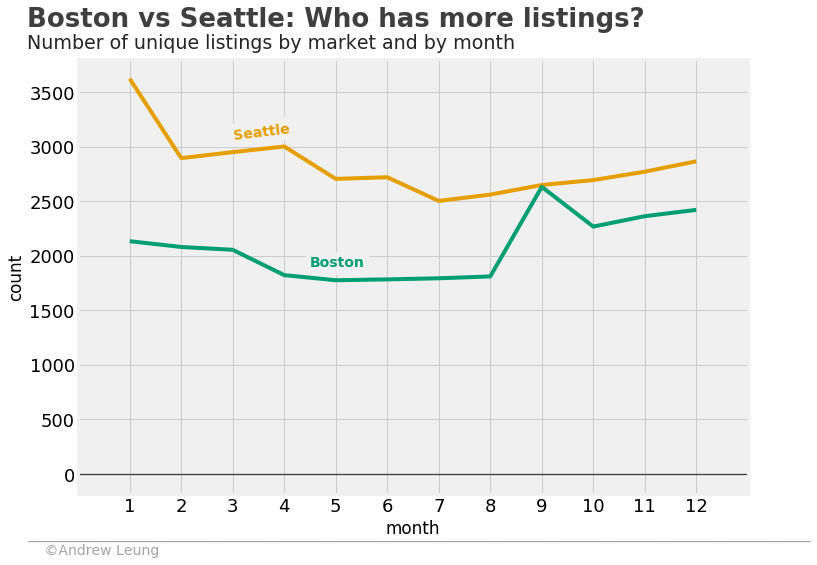

In [12]:
colors = [[230/255,159/255,0],[0,158/255,115/255]]


plt.figure(figsize=(12,8))
style.use('fivethirtyeight')
p1 = sns.lineplot("month","count",hue="city", palette = colors, legend=False,data=combined_monthly)
p1.tick_params(axis = 'both', which = 'major', labelsize = 18)
p1.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
p1.set_xlim(left = 0, right = 13)
p1.xaxis.set_major_locator(ticker.MultipleLocator(1))
p1.xaxis.set_major_formatter(ticker.ScalarFormatter())
p1.set_xticklabels(labels= [-1., "" ,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, "" , 14.] )

# The other signature bar
p1.text(x = -1, y = -600,
    s = '________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p1.text(x = -0.75, y = -740,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


p1.text(x = -1, y = 4100, s = "Boston vs Seattle: Who has more listings?",
                fontsize = 26, weight = 'bold', alpha = .75)
p1.text(x = -1, y = 3900,
               s = 'Number of unique listings by market and by month',
              fontsize = 19, alpha = .85)

p1.text(x = 3, y = 3070, s = 'Seattle', color = colors[0], weight = 'bold', rotation = 7,
        backgroundcolor = '#f0f0f0')

p1.text(x = 4.5, y = 1900, s = 'Boston', color = colors[1], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')

fig = p1.get_figure()
fig.savefig("p1_unique_listings.png") 
#p1.get_xticks()

In [13]:
#taking a look at min/max/mean
combined_monthly.groupby("city").agg(["min","max","mean","std"])

month                    count                           
          min max mean       std   min   max     mean         std
city                                                             
Boston      1  12  6.5  3.605551  1776  2632  2078.50  292.352682
Seattle     1  12  6.5  3.605551  2503  3623  2828.25  292.337018

In [14]:
combined_monthly

month  count     city
0       1   3623  Seattle
1       2   2895  Seattle
2       3   2950  Seattle
3       4   3002  Seattle
4       5   2705  Seattle
5       6   2720  Seattle
6       7   2503  Seattle
7       8   2561  Seattle
8       9   2649  Seattle
9      10   2694  Seattle
10     11   2771  Seattle
11     12   2866  Seattle
0       1   2134   Boston
1       2   2081   Boston
2       3   2055   Boston
3       4   1823   Boston
4       5   1776   Boston
5       6   1784   Boston
6       7   1794   Boston
7       8   1811   Boston
8       9   2632   Boston
9      10   2268   Boston
10     11   2363   Boston
11     12   2421   Boston

From this analysis, we see that the mean count of unique listings is higher in Seattle. The only exception is September, where Boston and Seattle appear to have about equal number of unqiue listings. We see the number of listings of Seattle hightest in January before a trend of decrease to July, after which, we see a slight slope upwards in the number of unqiue listings through to December.

For Boston, we see that the number unique listings remainly relatively flat year round except for a large spike in September, before leveling off again.

The standard deviations for each cities' counts is roughly the same, show a similar spread from the mean.


## Pricing - average prices by month and market

In [15]:
open_dates_sea.price = open_dates_sea.price.str.replace("[\$,]","", regex=True).astype(float)
open_dates_ba.price = open_dates_ba.price.str.replace("[\$,]","", regex=True).astype(float)

C:\Users\Andrew Leung\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
avg_prices_sea = open_dates_sea.groupby(open_dates_sea["month"])['price'].mean().reset_index()
avg_prices_sea["city"] = 'Seattle'

In [17]:
avg_prices_ba = open_dates_ba.groupby(open_dates_ba["month"])['price'].mean().reset_index()
avg_prices_ba["city"] = 'Boston'

In [18]:
prices_monthly = pd.concat([avg_prices_sea,avg_prices_ba])

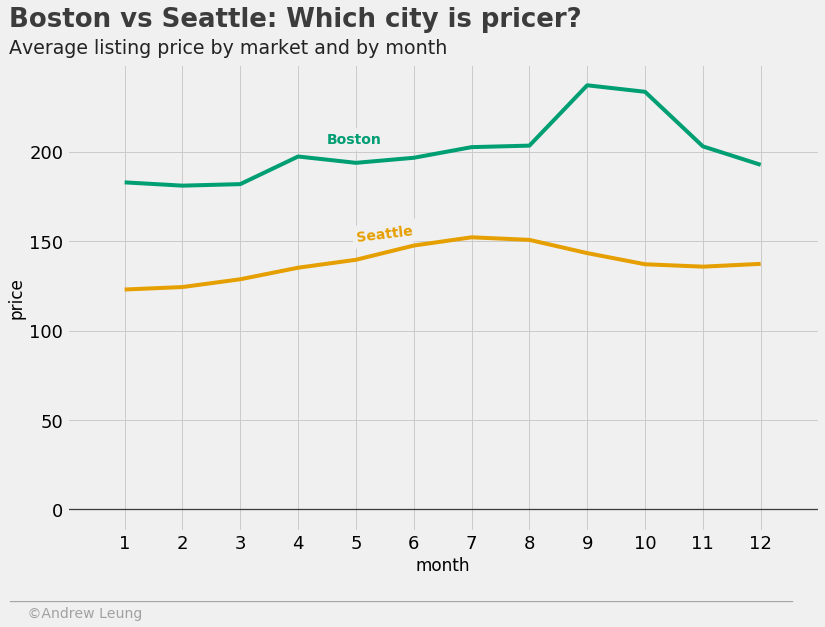

In [19]:
plt.figure(figsize=(12,8))
p2 = sns.lineplot("month","price",hue="city", palette=colors,legend=False,data=prices_monthly)
p2.tick_params(axis = 'both', which = 'major', labelsize = 18)
p2.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
p2.set_xlim(left = 0, right = 13)
p2.xaxis.set_major_locator(ticker.MultipleLocator(1))
p2.xaxis.set_major_formatter(ticker.ScalarFormatter())
p2.set_xticklabels(labels= [-1., "" ,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, "" , 14.] )

# The other signature bar
p2.text(x = -1, y = -50,
    s = '________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p2.text(x = -0.75, y = -60,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


#title and subtitle
p2.text(x = -1, y = 270, s = "Boston vs Seattle: Which city is pricer?",
                fontsize = 26, weight = 'bold', alpha = .75)
p2.text(x = -1, y = 255,
               s = 'Average listing price by market and by month',
              fontsize = 19, alpha = .85)

#city labels to replace legend
p2.text(x = 5, y = 150, s = 'Seattle', color = colors[0], weight = 'bold', rotation = 7,
        backgroundcolor = '#f0f0f0')

p2.text(x = 4.5, y = 205, s = 'Boston', color = colors[1], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')

fig2 = p2.get_figure()
fig2.savefig("p2_avg_price_per_listing.png",bbox_inches="tight") 

In [20]:
prices_monthly.groupby("city").agg(["min","max","mean","median","std"])
display(open_dates_ba.price.describe())
display(open_dates_sea.price.describe())


count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

We find that Boston pricing is in general higher than Seattle, which is not surprising as the overall availability of unique listings is greater in Boston and Seattle. This makes sense from a demand and supply perspective. The spread of pricing is almost greater in Boston as indicated by the differences in standard deviation. This appears to be due to the correspoinding increase in listing in September and October in Boston. Seattle's pricing is relatively must flatter, within a smaller range year round.

## Availability- average days available per listing

In [21]:
t = sea_cal.groupby(["month","available"])["listing_id"].count().reset_index()
t["denom"] = t.groupby("month")["listing_id"].transform("sum")

t["pct"]= t["listing_id"]/t["denom"]

t = t.merge(monthly_openings_sea, how='inner', on='month')
t["days_per_listing"] = t["listing_id"]/t["count"]


In [22]:
t2 = ba_cal.groupby(["month","available"])["listing_id"].count().reset_index()
t2["denom"] = t2.groupby("month")["listing_id"].transform("sum")
t2["pct"]= t2["listing_id"]/t2["denom"]

monthly_openings_ba

t2 = t2.merge(monthly_openings_ba, how='inner', on='month')
t2["days_per_listing"] = t2["listing_id"]/t2["count"] 
t2

avg_available = pd.concat([t,t2],axis=0)
avg_available = avg_available[avg_available["available"]=='t']
avg_available = avg_available[["month","available",'listing_id','count','city','days_per_listing']]
avg_available.rename(columns={"listing_id":"days_available","count":"num_unique_listings"},inplace=True)

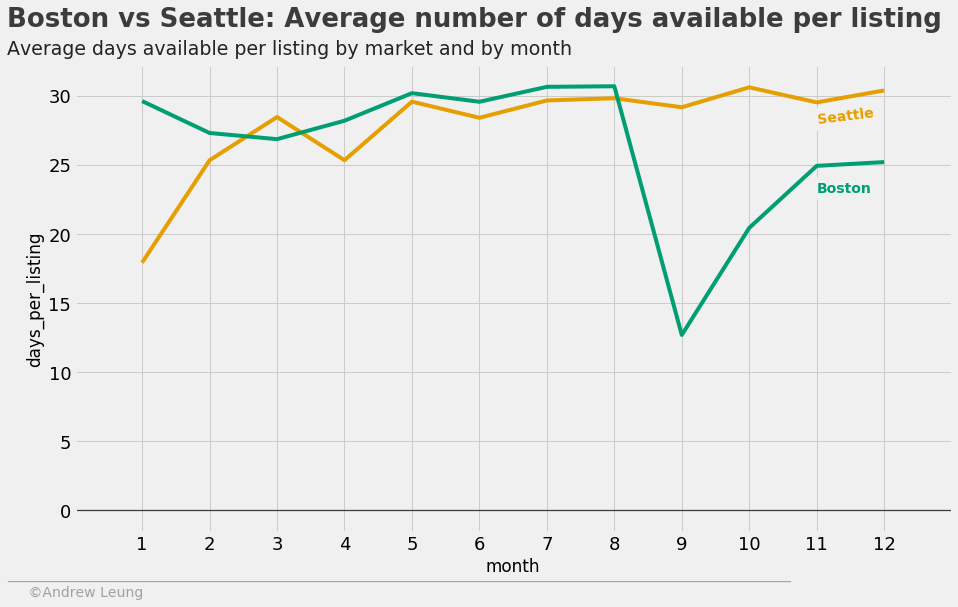

In [23]:
plt.figure(figsize=(14,8))
p3 = sns.lineplot("month","days_per_listing",hue="city", legend= False,palette=colors, data=avg_available)
p3.tick_params(axis = 'both', which = 'major', labelsize = 18)
p3.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
p3.set_xlim(left = 0, right = 13)
p3.xaxis.set_major_locator(ticker.MultipleLocator(1))
p3.xaxis.set_major_formatter(ticker.ScalarFormatter())
p3.set_xticklabels(labels= [-1., "" ,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, "" , 14.] )


# # The other signature bar
p3.text(x = -1, y = -5,
    s = '________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p3.text(x = -0.75, y = -6.25,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)

#title and subtitle
p3.text(x = -1, y = 35, s = "Boston vs Seattle: Average number of days available per listing",
                fontsize = 26, weight = 'bold', alpha = .75)
p3.text(x = -1, y = 33,
               s = 'Average days available per listing by market and by month',
              fontsize = 19, alpha = .85)

#city labels to replace legend
p3.text(x = 11, y = 28, s = 'Seattle', color = colors[0], weight = 'bold', rotation = 7,
        backgroundcolor = '#f0f0f0')

p3.text(x = 11, y = 23, s = 'Boston', color = colors[1], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')
fig3 = p3.get_figure()
fig3.savefig("p3_avg_days_per_listing.png") 

In [24]:
avg_available.groupby("city").agg(["min","max","mean","std"])

month                    days_available                       \
          min max mean       std            min    max          mean   
city                                                                   
Boston      1  12  6.5  3.605551          33398  63181  53586.416667   
Seattle     1  12  6.5  3.605551          64937  87061  77878.500000   

                     num_unique_listings                             \
                 std                 min   max     mean         std   
city                                                                  
Boston   7742.499977                1776  2632  2078.50  292.352682   
Seattle  5796.453673                2503  3623  2828.25  292.337018   

        days_per_listing                                  
                     min        max       mean       std  
city                                                      
Boston         12.689210  30.679735  26.353150  5.241479  
Seattle        17.923544  30.600594  27.842581  3.572545

In [25]:
avg_available

month available  days_available  num_unique_listings     city  \
1       1         t           64937                 3623  Seattle   
3       2         t           73321                 2895  Seattle   
5       3         t           83938                 2950  Seattle   
7       4         t           76037                 3002  Seattle   
9       5         t           79971                 2705  Seattle   
11      6         t           77244                 2720  Seattle   
13      7         t           74222                 2503  Seattle   
15      8         t           76347                 2561  Seattle   
17      9         t           77246                 2649  Seattle   
19     10         t           82438                 2694  Seattle   
21     11         t           81780                 2771  Seattle   
23     12         t           87061                 2866  Seattle   
1       1         t           63181                 2134   Boston   
3       2         t           56810                 2081   Boston   
5       3         t           55181                 2055   Boston   
7       4         t           51382                 1823   Boston   
9       5         t           53600                 1776   Boston   
11      6         t           52731                 1784   Boston   
13      7         t           54963                 1794   Boston   
15      8         t           55561                 1811   Boston   
17      9         t           33398                 2632   Boston   
19     10         t           46345                 2268   Boston   
21     11         t           58888                 2363   Boston   
23     12         t           60997                 2421   Boston   

    days_per_listing  
1          17.923544  
3          25.326770  
5          28.453559  
7          25.328781  
9          29.564140  
11         28.398529  
13         29.653216  
15         29.811402  
17         29.160438  
19         30.600594  
21         29.512811  
23         30.377181  
1          29.606842  
3          27.299375  
5          26.852068  
7          28.185409  
9          30.180180  
11         29.557735  
13         30.637124  
15         30.679735  
17         12.689210  
19         20.434303  
21         24.920863  
23         25.194961

While Seattle has a greater mean number of unique listings per month, we see that the average number of days available per listing by month is actually very similar between the two markets. Boston has a 26 available days per listing average over all all months, whereas Seattle has a 27.84 available days per listing average over all months. 

There are are however major differences in January where Seattle has an average of 17.92 days available per listing and Boston has 29.60 days available per listing on average. Inversely, in September Seattle has 29.16 days available per listing on average and Boston 12.68 days available per listing per average.



## Availability - Day of week by percentage (Overall and Month)

In [26]:
sea_wk = sea_cal[sea_cal["available"]=='t']
t = sea_wk.groupby(["weekday","weekday_int"])["listing_id"].count().reset_index()
t.rename(columns={"listing_id":"count"},inplace=True)
t

weekday  weekday_int   count
0     Friday            4  132803
1     Monday            0  135800
2   Saturday            5  132574
3     Sunday            6  133615
4   Thursday            3  132968
5    Tuesday            1  133407
6  Wednesday            2  133375

When we aggregate all of the listings day of week, we see that the raw count of available listings for each of the day of the week is roughly the same (~130k), as such, it doesn't seem like day of the week has any significant impact on available listings. This would seem ratherly unlikely. If we dig a bit further and look at the day of week by month, we see some significant differences.

In [27]:
sea_wk_mth = sea_wk.groupby(["month","weekday","weekday_int"])["listing_id"].count().reset_index()
sea_wk_mth

month    weekday  weekday_int  listing_id
0       1     Friday            4        8262
1       1     Monday            0       11172
2       1   Saturday            5        8315
3       1     Sunday            6       11667
4       1   Thursday            3        8367
..    ...        ...          ...         ...
79     12   Saturday            5       14064
80     12     Sunday            6       11223
81     12   Thursday            3       14023
82     12    Tuesday            1       11236
83     12  Wednesday            2       11245

[84 rows x 4 columns]

In [28]:
sea_wk_mth = sea_wk_mth.assign(denom = sea_wk_mth.groupby(["month"])["listing_id"].transform("sum"))
sea_wk_mth["pct_day_of_week"]=sea_wk_mth["listing_id"]/sea_wk_mth["denom"]
sea_wk_mth.sort_values(by=["weekday_int"],ascending=False,inplace=True)

In [29]:
sea_wk_mth

month weekday  weekday_int  listing_id  denom  pct_day_of_week
59      9  Sunday            6       10290  77246         0.133211
17      3  Sunday            6       10895  83938         0.129798
31      5  Sunday            6       12907  79971         0.161396
52      8  Sunday            6        9869  76347         0.129265
66     10  Sunday            6       13301  82438         0.161345
..    ...     ...          ...         ...    ...              ...
57      9  Monday            0       10303  77246         0.133379
43      7  Monday            0        9571  74222         0.128951
64     10  Monday            0       13308  82438         0.161430
15      3  Monday            0       10859  83938         0.129369
8       2  Monday            0       12741  73321         0.173770

[84 rows x 6 columns]

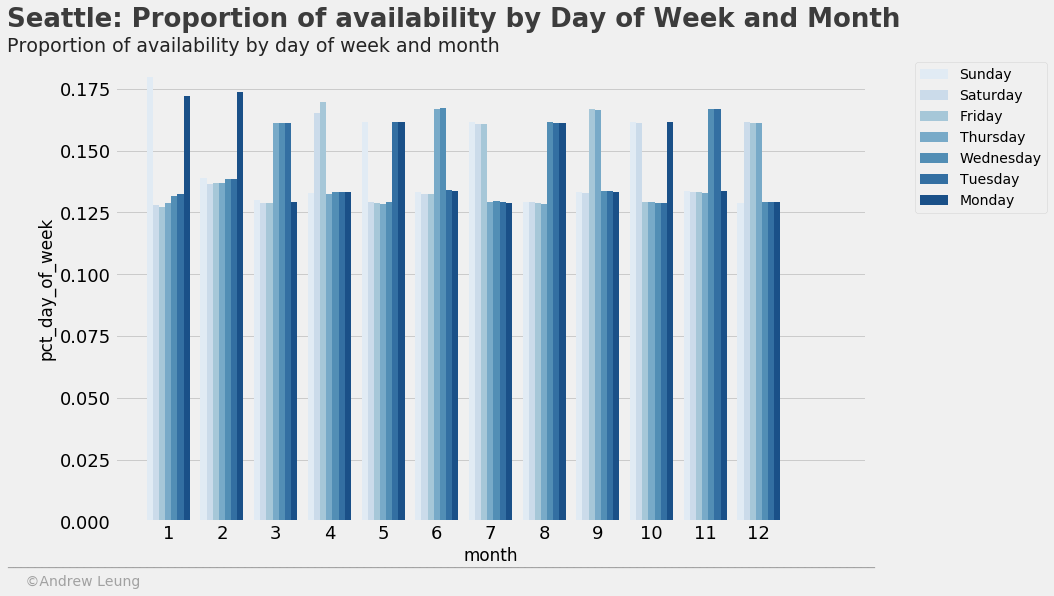

In [30]:
colors2 = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255], [204/255,121/255,161/255]]

plt.figure(figsize=(12,8))
p4 = sns.barplot("month","pct_day_of_week",hue="weekday", palette="Blues", data=sea_wk_mth)
p4.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
p4.tick_params(axis = 'both', which = 'major', labelsize = 18)
p4.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
p4.set_xlim(left = -1, right = 13)


# The other signature bar
p4.text(x = -3, y = -0.018,
    s = '____________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p4.text(x = -2.75, y = -0.026,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


#title and subtitle
p4.text(x = -3, y = .2, s = "Seattle: Proportion of availability by Day of Week and Month",
                fontsize = 26, weight = 'bold', alpha = .75)
p4.text(x = -3, y = .190,
               s = 'Proportion of availability by day of week and month',
              fontsize = 19, alpha = .85)

fig4 = p4.get_figure()
fig4.savefig("p4sea_proportion_dow.png",bbox_inches="tight") 

In [31]:
sea_wk_mth.groupby("weekday")["pct_day_of_week"].agg(["min","max","mean","std"])

min       max      mean       std
weekday                                          
Friday     0.127231  0.169654  0.142017  0.017044
Monday     0.128951  0.173770  0.145941  0.018209
Saturday   0.128047  0.165354  0.141592  0.015450
Sunday     0.128910  0.179666  0.143611  0.017369
Thursday   0.128509  0.166667  0.141837  0.016502
Tuesday    0.128885  0.166606  0.142479  0.015150
Wednesday  0.128945  0.167262  0.142523  0.016339

By month in Seattle, we see some signficant variation by day of the week.

In [32]:
ba_wk = ba_cal[ba_cal["available"]=='t']
ba_wk.groupby(["weekday","weekday_int"])["listing_id"].count().reset_index()

weekday  weekday_int  listing_id
0     Friday            4       90998
1     Monday            0       92413
2   Saturday            5       91068
3     Sunday            6       92208
4   Thursday            3       91202
5    Tuesday            1       93332
6  Wednesday            2       91816

In [33]:
ba_wk_mth = ba_wk.groupby(["month","weekday","weekday_int"])["listing_id"].count().reset_index()
ba_wk_mth

month    weekday  weekday_int  listing_id
0       1     Friday            4        8177
1       1     Monday            0       10171
2       1   Saturday            5        8184
3       1     Sunday            6       10177
4       1   Thursday            3        8158
..    ...        ...          ...         ...
79     12   Saturday            5        9985
80     12     Sunday            6        8019
81     12   Thursday            3        9880
82     12    Tuesday            1        7714
83     12  Wednesday            2        7746

[84 rows x 4 columns]

In [34]:
ba_wk_mth = ba_wk_mth.assign(denom = ba_wk_mth.groupby(["month"])["listing_id"].transform("sum"))
ba_wk_mth["pct_day_of_week"]=ba_wk_mth["listing_id"]/ba_wk_mth["denom"]
ba_wk_mth.sort_values(by=["weekday_int"],ascending=False,inplace=True)

In [35]:
ba_wk_mth

month weekday  weekday_int  listing_id  denom  pct_day_of_week
59      9  Sunday            6        4896  33398         0.146596
17      3  Sunday            6        6979  55181         0.126475
31      5  Sunday            6        6913  53600         0.128974
52      8  Sunday            6        7173  55561         0.129101
66     10  Sunday            6        7490  46345         0.161614
..    ...     ...          ...         ...    ...              ...
57      9  Monday            0        4948  33398         0.148153
43      7  Monday            0        8859  54963         0.161181
64     10  Monday            0        7990  46345         0.172403
15      3  Monday            0        6965  55181         0.126221
8       2  Monday            0        8116  56810         0.142862

[84 rows x 6 columns]

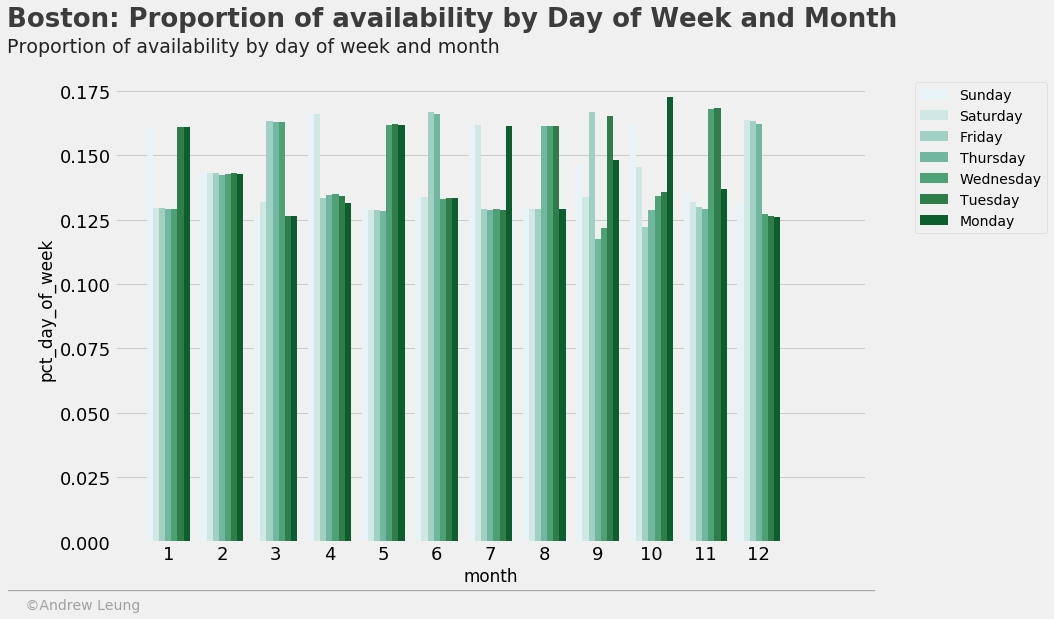

In [36]:
plt.figure(figsize=(12,8))
p5 = sns.barplot("month","pct_day_of_week",hue="weekday", palette="BuGn", data=ba_wk_mth)
p5.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
p5.tick_params(axis = 'both', which = 'major', labelsize = 18)
p5.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
p5.set_xlim(left = -1, right = 13)


# The other signature bar
p5.text(x = -3, y = -0.018,
    s = '____________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p5.text(x = -2.75, y = -0.026,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


#title and subtitle
p5.text(x = -3, y = .2, s = "Boston: Proportion of availability by Day of Week and Month",
                fontsize = 26, weight = 'bold', alpha = .75)
p5.text(x = -3, y = .190,
               s = 'Proportion of availability by day of week and month',
              fontsize = 19, alpha = .85)


fig5 = p5.get_figure()
fig5.savefig("p5ba_proportion_dow.png",bbox_inches="tight") 

In [37]:
ba_wk_mth.groupby("weekday")["pct_day_of_week"].agg(["min","max","mean","std"])

min       max      mean       std
weekday                                          
Friday     0.122214  0.166926  0.142126  0.017615
Monday     0.126154  0.172403  0.144177  0.016245
Saturday   0.128582  0.166011  0.141511  0.014414
Sunday     0.126475  0.165895  0.143750  0.015003
Thursday   0.117402  0.166088  0.140898  0.017327
Tuesday    0.126384  0.168303  0.145447  0.016676
Wednesday  0.121804  0.167963  0.142092  0.016629

Again with boston, we see significant month to month variation for day of the week

In [38]:
#read the dataset
listings_sea = pd.read_csv('./input/sea_listings.csv')
listings_ba = pd.read_csv('./input/ba_listings.csv')

## Amenities - Differences in proportion of listings with amenities

To take a look at the amenities, I first had to parse out the "amenities" column and then create dummy variables to indicate the presence of an amenity in a listing. The dummies were then summed and proportions were created. The following was the final business question:


<blockquote>1. Are there differences in available amenities between the listings in Seattle and Boston?  </blockquote>

In [39]:
listings_sea.shape

(3818, 92)

In [40]:
def dummy_columns_from_list(row, column_name, value):
    ''' Fill in dummy column for values 
    
    '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

In [41]:
def list_field_to_dict_and_proportions(df,col_name):
    '''
    Function to find all listed amenities and to count them from the col_name column. This will create a master list  
   of variables and value counts. From this list, the original "amenities" column is parsed into dummy columns using the
   dummy_columns_from_list function. This nested function takes each amenity and searches each row. If the amenity is found
   the "amenities" column for that row, a 1 is returned, else 0 is returned. 
   
   To create the proprotions of listing with the amenities, a seperate dataframe is created that only selects the new
   amenity dummy columns. They are summed and divided by the number of rows (number of listings). Both the list of amenities
   with value counts and a df with the proportions of listing with each amenity is returned.
   
   Inputs:
   1. df - data frame with the column to split - in this case the Boston and Seattle listings.csv
   2. col_name - the column name with the list of features to split and count
   
   Outputs:
   1. value_sorted - list of all available feautres parsed from column and value_counts
   2. adf - a long table with the proportion of properties is provided
    '''
    values_dict = {}

    for unique_value in df[col_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] += 1
            else:
                values_dict[value] = 0

    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)

    for value in values_sorted:
        df[col_name + '_' + value[0]] =df.apply(lambda row: dummy_columns_from_list(row, col_name, value[0]),axis=1)
    
    amenities = [i for i in df.columns if re.match("amenities_",i)]
    amenities = [i for i in amenities if i != "amenities_"]
    
    adf = df[amenities]
    adf.columns = [re.sub("amenities_","",i) for i in adf.columns.tolist()]
        
    adf = adf.sum().div(adf.shape[0]).reset_index()
    
    return values_sorted, adf

In [42]:
sea_alist, sea_pcts = list_field_to_dict_and_proportions(listings_sea,"amenities")

In [43]:
ba_alist, ba_pcts = list_field_to_dict_and_proportions(listings_ba,"amenities")

In [44]:
diff_df = pd.merge(sea_pcts, ba_pcts, left_index=True, right_index=True)
diff_df['Diff_in_pct'] = diff_df['0_x'] - diff_df['0_y']
diff_df.drop(columns=["index_y"],inplace=True)
diff_df.rename(columns={'index_x':'amenity','0_x':'sea_listing_pct', '0_y':'ba_listing_pct'},inplace=True)
diff_df.sort_values(by=["Diff_in_pct"],ascending=False, inplace=True)
diff_df.style.bar(subset=['Diff_in_pct'], align='mid', color=['#d65f5f', '#5fba7d'])


In [45]:
import imgkit
path_wkthmltoimage = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe'
config = imgkit.config(wkhtmltoimage=path_wkthmltoimage)


In [46]:
ax = diff_df.style.bar(subset=['Diff_in_pct'], align='mid', color=['#d65f5f', '#5fba7d'])
html = ax.render()
imgkit.from_string(html, 'styled_table.png',config=config)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [47]:
#function debugging
t=['amenities_Free Parking on Premises','amenities_Free Parking on Premises2','amenities_Free Parking on Premises3']
[re.sub("amenities_","",i) for i in t]

['Free Parking on Premises',
 'Free Parking on Premises2',
 'Free Parking on Premises3']

After I used that styled table, I experimented with other ways to plot the bar graph:

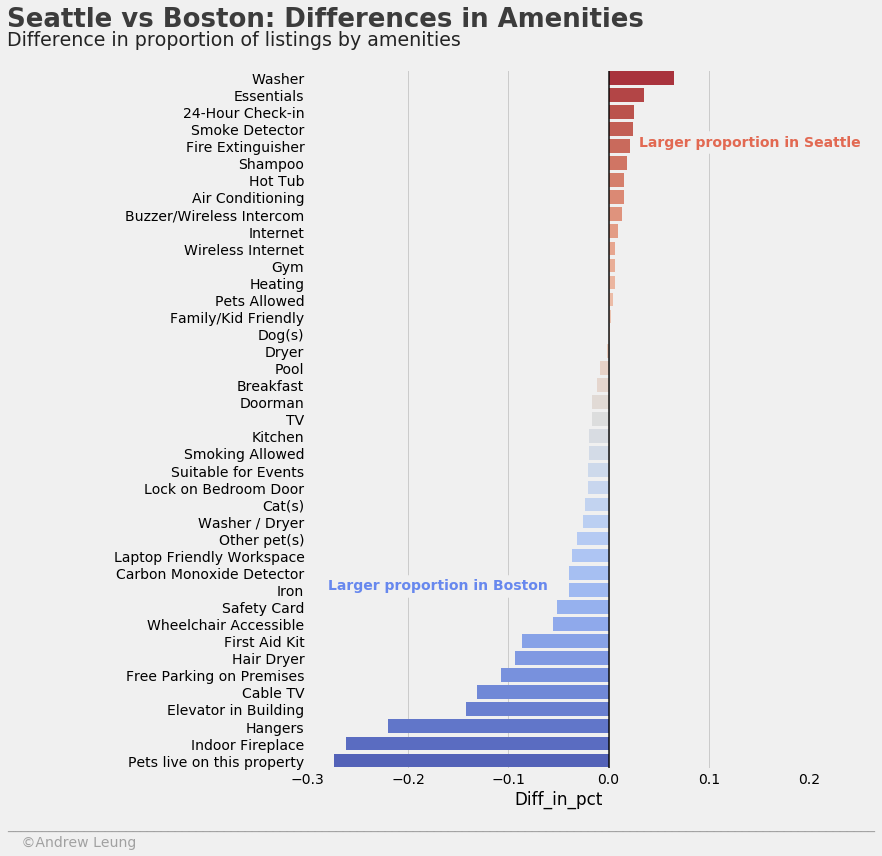

In [48]:
plt.figure(figsize=(8,12))
p6 = sns.barplot("Diff_in_pct","amenity", palette="coolwarm_r", data=diff_df)
p6.tick_params(axis = 'both', which = 'major', labelsize = 14)
p6.axvline(x = 0, color = 'black', linewidth = 2, alpha = .7)
p6.set_xlim(left = -0.3, right = 0.2)
p6.yaxis.label.set_visible(False)


# The other signature bar
p6.text(x = -.6,y = 44,
    s = '____________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p6.text(x = -.59, y = 45,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


#title and subtitle
p6.text(x = -.6, y = -3, s = "Seattle vs Boston: Differences in Amenities",
                fontsize = 26, weight = 'bold', alpha = .75)
p6.text(x = -.6, y = -1.90,
               s = 'Difference in proportion of listings by amenities',
              fontsize = 19, alpha = .85)

#city labels to replace legend
p6.text(x = -.28, y= 30,s = 'Larger proportion in Boston', color = [0.4044212904941176, 0.5346434904470588, 0.9320019126352941], weight = 'bold', rotation = 0,
        backgroundcolor = '#f0f0f0')

p6.text(x = .03, y= 4, s = 'Larger proportion in Seattle', color = [0.8846434386941177, 0.41001709788235297, 0.32250654924705885], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')


fig6 = p6.get_figure()
fig6.savefig("p6_proportion_amenities.png",bbox_inches="tight") 

From this horizontal bar graph it becomes very apparent that there are differences in the porportion of listings with certain amentities between the two cities. The range of differences is also much larger for amenities more available in boston, compared to amenities more availabe in Seattle listing.


[(0.4044212904941176, 0.5346434904470588, 0.9320019126352941),
 (0.603162067917647, 0.7315274773529412, 0.9995652785372549),
 (0.7867207013568628, 0.8448072103686275, 0.9398103849490196),
 (0.9306685963333333, 0.818876999654902, 0.7591463906980392),
 (0.9673165156666667, 0.6574708288078431, 0.5381601507294118),
 (0.8846434386941177, 0.41001709788235297, 0.32250654924705885)]

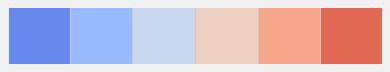

In [49]:
sns.palplot(sns.color_palette("coolwarm"))
sns.color_palette("coolwarm")

The code for zooming in to the top five amenity differences in favour of each city.

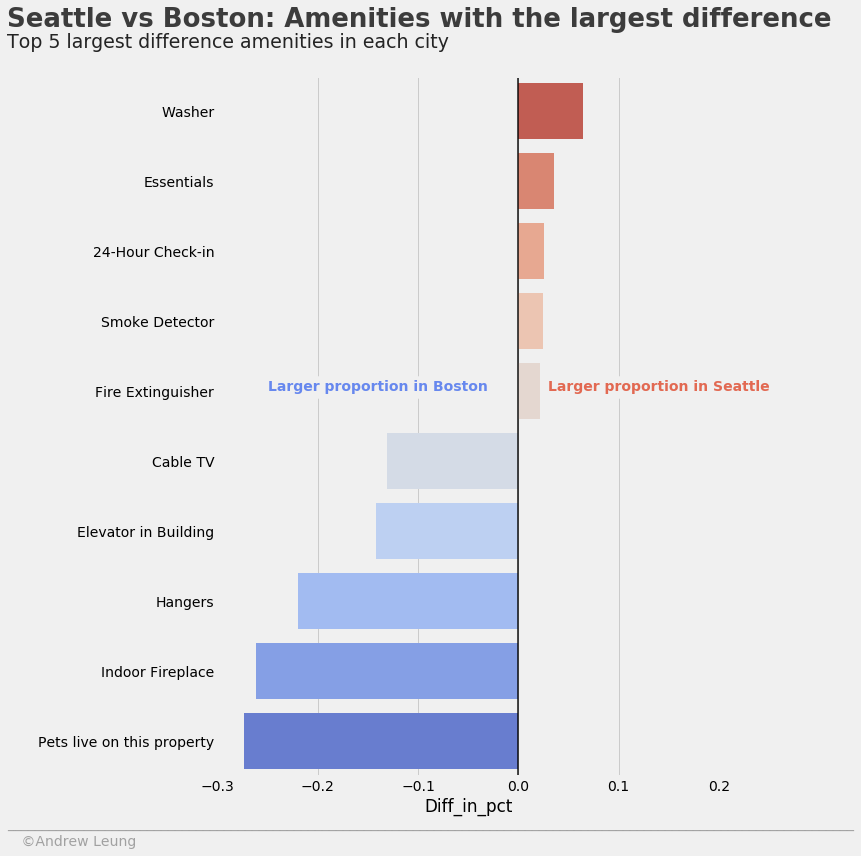

In [50]:
plt.figure(figsize=(8,12))
p7 = sns.barplot("Diff_in_pct","amenity", palette="coolwarm_r", data=diff_df[(diff_df["Diff_in_pct"]>.02)|(diff_df["Diff_in_pct"]< -.11)])
p7.tick_params(axis = 'both', which = 'major', labelsize = 14)
p7.axvline(x = 0, color = 'black', linewidth = 2, alpha = .7)
p7.set_xlim(left = -0.3, right = 0.2)
p7.yaxis.label.set_visible(False)

# The other signature bar
p7.text(x = -.51, y = 10.25,
    s = '_________________________________________________________________________________________________________________________',
    color = 'grey', alpha = .7)

p7.text(x = -.5, y = 10.5,
    s = ' ©Andrew Leung                                                                                            ',
    fontsize = 14, color = 'grey', alpha = .7)


#title and subtitle
p7.text(x = -.51, y = -1.2, s = "Seattle vs Boston: Amenities with the largest difference",
                fontsize = 26, weight = 'bold', alpha = .75)
p7.text(x = -.51, y = -0.90,
               s = 'Top 5 largest difference amenities in each city',
              fontsize = 19, alpha = .85)

#city labels to replace legend
p7.text(x = -.25, y = 4,s = 'Larger proportion in Boston', color = [0.4044212904941176, 0.5346434904470588, 0.9320019126352941], weight = 'bold', rotation = 0,
        backgroundcolor = '#f0f0f0')

p7.text(x = .03, y= 4, s = 'Larger proportion in Seattle', color = [0.8846434386941177, 0.41001709788235297, 0.32250654924705885], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')

fig7 = p7.get_figure()
fig7.savefig("p7_zoomed_proportion_amenities.png",bbox_inches="tight") 

If take a look at the top 5 differences in each city, we see that Seattle has a larger proportion of listings with allowing pets, indoor fireplaces, hangers, elevators and cable TV, while Seattle has more listings with Washers, Essentials, Check-In and smoke detector. It appears that Boston listings all seem to have a greater number of luxury and perhaps less essential amenities. There is a possiblity that due to the lower supply of AirBnB homes in Boston, coupled with higher pricing, the Boston listings need more secondary features/amenities to stay competitive relative to other listings.

## References

1. https://www.kaggle.com/airbnb/seattle?select=calendar.csv (data set)
2. https://www.kaggle.com/airbnb/boston?select=calendar.csv (data set)
3. https://stackoverflow.com/questions/32244753/how-to-save-a-seaborn-plot-into-a-file
4. https://stackoverflow.com/questions/26763344/convert-pandas-column-to-datetime
5. https://docs.python.org/3/library/datetime.html#date-objects
6. https://stackoverflow.com/questions/26105804/extract-month-from-date-in-python/26105888
7. https://stackoverflow.com/questions/41415017/count-unique-values-using-pandas-groupby
8. https://seaborn.pydata.org/tutorial/color_palettes.html
9. https://stackoverflow.com/questions/34990652/why-do-we-need-np-squeeze
10. https://www.dataquest.io/blog/making-538-plots/
11. https://stackoverflow.com/questions/44521648/tick-frequency-when-using-seaborn-matplotlib-boxplot
12. https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
13. https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure
14. https://stackoverflow.com/questions/47271419/unexpected-error-while-executing-imgkit
15. https://help.medium.com/hc/en-us/articles/225168768-Write-a-post
16. https://livability.com/ma/boston/experiences-adventures/seattle-vs-boston-a-showdown-of-super-bowl-cities (image source)
17. https://www.wallpaperflare.com/boeing-747-8-aircraft-takeoff-dawn-lufthansa-wallpaper-mwomu (Image source)
18. https://www.wallpaperflare.com/seattle-skyline-seattle-golden-seattle-wa-washington-seattle-center-wallpaper-mrfvw/download/2560x1080 (image source)
19. https://www.wallpaperflare.com/reflection-cityscape-skyline-urban-area-metropolitan-area-wallpaper-tmtmu/download/2560x1080 (image source)
20. https://www.kaggle.com/aleksandradeis/airbnb-seattle-reservation-prices-analysis#Conclusion (parsing amenities column)
21. https://towardsdatascience.com/airbnb-listings-in-seattle-a-deeper-look-4fc4dad3e34e (example for reference)
22. https://medium.com/@josh_2774/a-comparison-of-airbnb-homes-seattle-vs-boston-cdc0df2cfcd7 (example for reference)
23. https://medium.com/@josh_2774/how-do-you-become-a-developer-5ef1c1c68711 (example for reference)
24. https://stackoverflow.com/questions/49201174/the-seaborn-not-saving-the-whole-figure-but-only-part-of-it